## Image segmentation with U-Net

This part of the homework is about image segmentation with <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>.

### What is image segmentation?

There is a large number of tasks where you need to know not only the presence of an object in the picture, but its location and exact shape.This is precisely the task that image segmentation copes with, which puts a class label for each pixel, as opposed to image classification, which labels each image.

This task uses the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), created by Parkhi *et al*. The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the train and test split). Each pixel of an animal image corresponds to one of three classes: a pixel belonging to a pet; a pixel located at the border of a pet; all other pixels. 

Данное задание предстоит выполнить на фреймворке Tensorflow 2 с помощью Ke ras, подробнее о том, как использовать Keras и примеры вы можете найти по [ссылке](https://www.tensorflow.org/guide/keras/sequential_model)

### Preprocessing

#### Download the data

Please make sure you select the **GPU** runtime environment!!!

In [6]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2023-02-21 05:09:12--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-02-21 05:09:13--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  29.7MB/s    in 26s     

2023-02-21 05:09:40 (28.8 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2023-02-21 05:09:40--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.ta

#### Prepare paths of input images

In [7]:
import os 

def get_paths(files_dir: str, files_type: str):
    paths = sorted(
        [
            os.path.join(files_dir, file_name)
            for file_name in os.listdir(files_dir)
            if file_name.endswith(f".{files_type}") and not file_name.startswith(".")
        ]
    )
    return paths


images_dir = "images/"
masks_dir = "annotations/trimaps/"

images_paths = get_paths(images_dir, "jpg")
masks_paths = get_paths(masks_dir, "png")

img_size = (128, 128)
num_classes = 3

print("Number of samples:", len(images_paths))

Number of samples: 7390


#### Show example of data

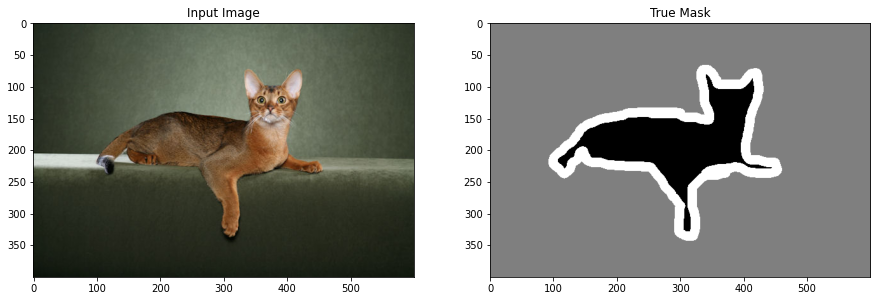

In [8]:
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

import numpy as np
import matplotlib.pyplot as plt

# display original image, true mask, and predicted mask (optional)
# all images are np.arrays or PIL.Image
def display_sample(display_list):
    titles = ['Input Image', 'True Mask', 'Predicted Mask'][:len(display_list)]
    plt.figure(figsize=(15, 15))
    columns = len(titles)
    
    for i, image in enumerate(display_list):
        plt.subplot(1, columns, i + 1)
        plt.title(titles[i])
        plt.imshow(np.asarray(image))
    
def load_image_and_mask(images_paths, masks_paths, ind):
    image = load_img(images_paths[ind])
    mask = PIL.ImageOps.autocontrast(load_img(masks_paths[ind]))
    return (image, mask, )

sample = load_image_and_mask(images_paths, masks_paths, 0)
display_sample(sample)

(128, 128, 3) (128, 128)


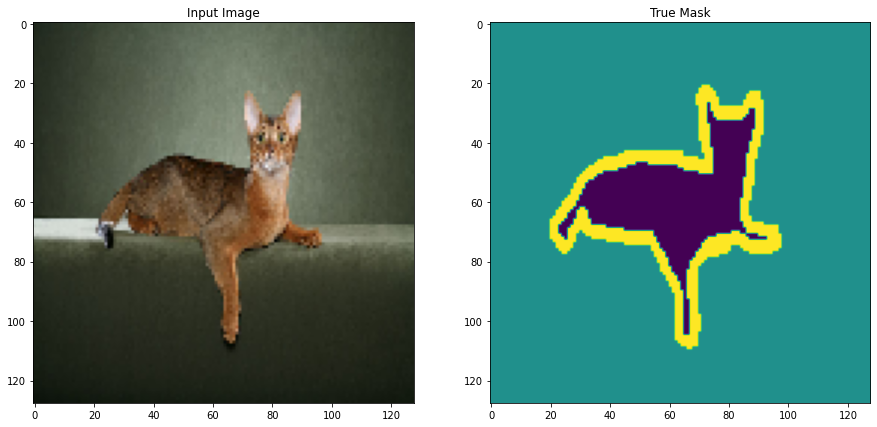

In [10]:
image = np.asarray(load_img(images_paths[0], target_size=img_size))
mask = np.array(load_img(masks_paths[0], target_size=img_size, color_mode="grayscale"))

print(np.shape(image), np.shape(mask))
display_sample((image, mask))

#### Task 1: Set Sequence for training process

In this task you need to implement two methods for the Sequence class used for model training and validation: __len__ and __getitem__.



Note: `Sequence` are a safer way to do multiprocessing. This structure guarantees
that the network will only train once
on each sample per epoch which is not the case with generators.

In [11]:
import tensorflow as tf
from tensorflow import keras
from skimage.transform import resize
import math


class PetsSequence(keras.utils.Sequence):
    
    def __init__(self, batch_size, img_size, images_paths, masks_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.images_paths = images_paths
        self.masks_paths = masks_paths
    

    def __len__(self):
        # Each item in the sequence has a size of batch_size, this method returns the number of batches. Shoud be integer!
        return math.ceil(len(self.images_paths) / self.batch_size) - 1       
    

    def __getitem__(self, idx):

        """
        This method returns the batches themselves including images (x) and masks (y) as np.arrays.
        Correspondingly x contains the batch_size of the pet images, y the true segmentation of the images from x.
        Note:
            1) You can use tensorflow.keras.preprocessing.image.load_img with the specified parameter "target_size" 
                (for reading masks for reading masks is a convenient is parametercolor_mode="grayscale")
            2) Don't forget to normalize the images and masks 
                ( img / 255.0 for images, so that each value is adjacent to the interval [0, 1] 
                and mask -= 1 for segmented images, to get {0, 1, 2} instead of the original labels {1, 2, 3} ) 
        """

        x = np.zeros((self.batch_size, *self.img_size, 3), dtype="float32")
        y = np.zeros((self.batch_size, *self.img_size, 1), dtype="uint8")
        
        for i in range(self.batch_size):

            x_i = np.array(load_img(images_paths[idx * self.batch_size + i], target_size=self.img_size))
            x[i] = tf.cast(x_i, tf.float32) / 255.0

            y_i = np.array(load_img(masks_paths[idx * self.batch_size + i],
                                    target_size=self.img_size,
                                    color_mode="grayscale")) - 1
            y_i.resize(*img_size, 1)
            y[i] = y_i

        return (x, y)


batch_size = 32
seq = PetsSequence(batch_size, img_size, images_paths, masks_paths)

print(len(seq))
x, y = seq.__getitem__(5)
y.sum()

230


438676

Test for task 1. Please do not change the code in the cell below, it is just to make sure that your implementation of Sequence is set correctly

In [12]:
sequence = PetsSequence(32, (128, 128), images_paths, masks_paths)


if type(sequence.__len__()) != int:
    print("Error: __len__ value should be integer \n")
elif not (sequence.__len__() == 230 or sequence.__len__() == 231):
    print("Wrong answer for __len__ realization\n")
else:
    print("Method __len__ is correct!")
    
if len(sequence.__getitem__(5)) != 2:
    print("Error: __getitem__ Must return a tuple of two elements") 
else:
    x, y = sequence.__getitem__(5)
    if type(x) != np.ndarray or type(y) != np.ndarray:
        print("Error: x and y shoud have type numpy.ndarray")
    elif x.shape != (32, 128, 128, 3):
        print("Error: x shoud has shape (batch_size, img_size_x, img_size_y, 3)")
    elif y.shape != (32, 128, 128, 1):
        print("Error: y shoud has shape (batch_size, img_size_x, img_size_y, 1)")
    elif y.sum() == 962964:
        print("Wrong answer: there is no normalization for y")
    elif y.sum() != 438676:
        print("Wrong answer for y")
    elif x.sum() >= 167121500.0 and x.sum() <= 167122500.0:
        print("Wrong answer: there is no normalization for x")
    elif not (x.sum() >= 655200.0 and x.sum() <= 655600.0):
        print("Wrong answer for x")
    else:
        print("Method __getitem__ is correct!")

Method __len__ is correct!
Method __getitem__ is correct!


### Base U-Net

#### Task 2: U-Net architecture

In this task you need to describe the architecture of the neural network by implementing the get_unet_model method.

Note: You can use padding="same" in convolution layers to simplify the network structure and avoid cropping.

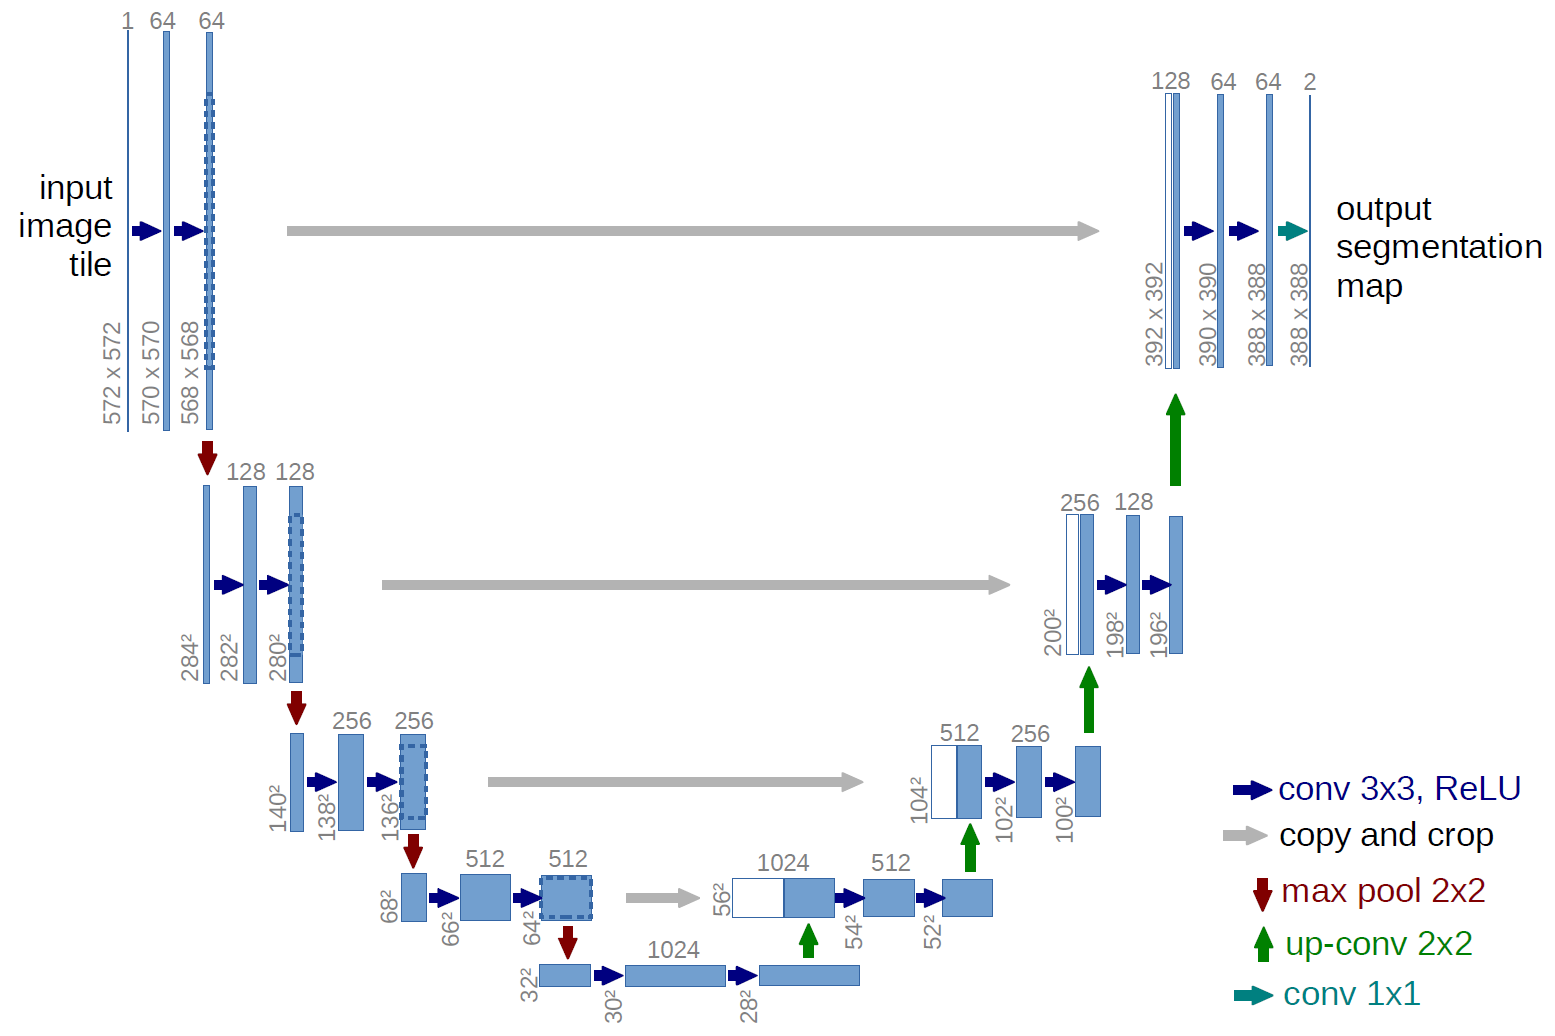



In this task you will be able to use MaxPooling2D(pool_size=(2, 2)), UpSampling2D(size = (2,2)), Concatenate().

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Concatenate, MaxPooling2D, UpSampling2D


def get_unet_model(img_size, num_classes):

    inputs = keras.Input(shape=(*img_size, 3))
    
    # --- Encoder ---

    conv_layer_1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv_layer_1 = Conv2D(64, 3, activation='relu', padding='same')(conv_layer_1)
    pooled_1 = MaxPooling2D(pool_size=(2, 2))(conv_layer_1)

    conv_layer_2 = Conv2D(128, 3, activation='relu', padding='same')(pooled_1)
    conv_layer_2 = Conv2D(128, 3, activation='relu', padding='same')(conv_layer_2)
    pooled_2 = MaxPooling2D(pool_size=(2, 2))(conv_layer_2)

    conv_layer_3 = Conv2D(256, 3, activation='relu', padding='same')(pooled_2)
    conv_layer_3 = Conv2D(256, 3, activation='relu', padding='same')(conv_layer_3)
    pooled_3 = MaxPooling2D(pool_size=(2, 2))(conv_layer_3)

    conv_layer_4 = Conv2D(512, 3, activation='relu', padding='same')(pooled_3)
    conv_layer_4 = Conv2D(512, 3, activation='relu', padding='same')(conv_layer_4)
    pooled_4 = MaxPooling2D(pool_size=(2, 2))(conv_layer_4)

    conv_layer_5 = Conv2D(1024, 3, activation='relu', padding='same')(pooled_4)
    conv_layer_5 = Conv2D(1024, 3, activation='relu', padding='same')(conv_layer_5)

    # --- End of Encoder ---


    # --- Decoder --- 
  
    upsampled_1 =  Conv2D(512, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv_layer_5))

    concat_1 = Concatenate()([conv_layer_4, upsampled_1])
    conv_layer_6 = Conv2D(512, 2, activation='relu', padding='same')(concat_1)
    conv_layer_6 = Conv2D(512, 2, activation='relu', padding='same')(conv_layer_6)
    upsampled_2 = Conv2D(256, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv_layer_6))


    concat_2 = Concatenate()([conv_layer_3, upsampled_2])
    conv_layer_7 = Conv2D(256, 3, activation='relu', padding='same')(concat_2)
    conv_layer_7 = Conv2D(256, 3, activation='relu', padding='same')(conv_layer_7)
    upsampled_3 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv_layer_7))

    concat_3 = Concatenate()([conv_layer_2, upsampled_3])
    conv_layer_8 = Conv2D(128, 3, activation='relu', padding='same')(concat_3)
    conv_layer_8 = Conv2D(128, 3, activation='relu', padding='same')(conv_layer_8)
    upsampled_4 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv_layer_8))

    concat_4 = Concatenate()([conv_layer_1, upsampled_4])
    conv_layer_9 = Conv2D(128, 3, activation='relu', padding='same')(concat_4)
    conv_layer_9 = Conv2D(64, 3, activation='relu', padding='same')(conv_layer_9)
    conv_layer_9 = Conv2D(64, 3, activation='relu', padding='same')(conv_layer_9)

    # --- End of Decoder ---
    
    outputs = Conv2D(num_classes, 3, activation="softmax", padding="same")(conv_layer_9)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
model = get_unet_model(img_size, num_classes)

You can check the correctness of the model by comparing the U-Net architecture and the output of keras.utils.plot_model

In [ ]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(images_paths)
random.Random(1337).shuffle(masks_paths)
train_input_img_paths = images_paths[:-val_samples]
train_target_img_paths = masks_paths[:-val_samples]
val_input_img_paths = images_paths[-val_samples:]
val_target_img_paths = masks_paths[-val_samples:]

# Instantiate data Sequences for each split
batch_size = 32
train_gen = PetsSequence(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = PetsSequence(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/15
199/199 [==============================] - 180s 786ms/step - loss: 0.8911 - val_loss: 0.7630
Epoch 2/15
199/199 [==============================] - 156s 785ms/step - loss: 0.7849 - val_loss: 0.7802
Epoch 3/15
199/199 [==============================] - 155s 781ms/step - loss: 0.7098 - val_loss: 0.7077
Epoch 4/15
199/199 [==============================] - 155s 778ms/step - loss: 0.6676 - val_loss: 0.6613
Epoch 5/15
199/199 [==============================] - 156s 783ms/step - loss: 0.6088 - val_loss: 0.5602
Epoch 6/15
199/199 [==============================] - 154s 777ms/step - loss: 0.5722 - val_loss: 0.4899
Epoch 7/15
199/199 [==============================] - 171s 862ms/step - loss: 0.5461 - val_loss: 0.5110
Epoch 8/15
199/199 [==============================] - 160s 804ms/step - loss: 0.5030 - val_loss: 0.4380
Epoch 9/15
199/199 [==============================] - 156s 782ms/step - loss: 0.4681 - val_loss: 0.4206
Epoch 10/15
199/199 [==============================] - 165s 831m

In [ ]:
# predict segmentation for validation dataset
# It is not necessary to predict the result for the whole dataset, you can limit yourself to one batch from the validation dataset 

val_gen = PetsSequence(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

31/31 [==============================] - 11s 345ms/step


In [37]:
def prediction_to_img(prediction):
    prediction = np.argmax(prediction, axis=-1)
    prediction = np.expand_dims(prediction, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(prediction))
    return img 

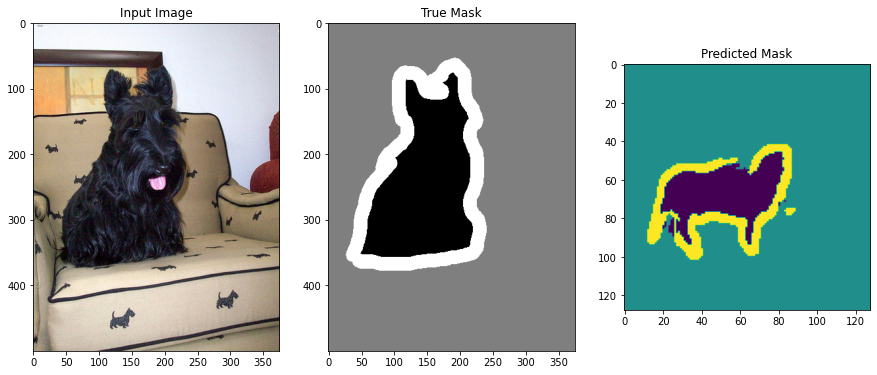

In [ ]:
# display one sample prediction

i = 17

sample = load_image_and_mask(val_input_img_paths, val_target_img_paths, i)
prediction = prediction_to_img(val_preds[i])
sample += (prediction,)
display_sample(sample)

# I don't know why image and it's mask mismatches with predicted mask by number.
# I wrote my own visualization below, in those it all works. 

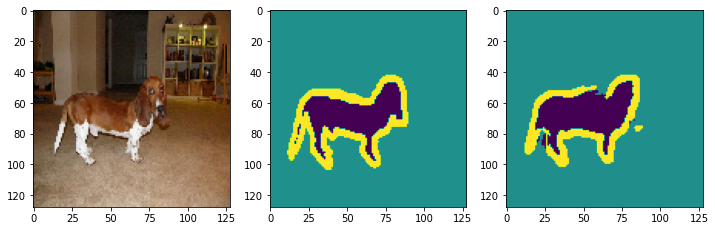

In [ ]:
image_num_to_display = 17 # < batch_size
img_shape = (128, 128)

fig, axs = plt.subplots(1, 3, figsize=(12, 8))

for image, mask in val_gen:
  axs[0].imshow(image[image_num_to_display])
  axs[1].imshow([[mask[image_num_to_display][i][j][0] for j in range(img_shape[1])]
                 for i in range(img_shape[0])])
  axs[2].imshow(prediction_to_img(val_preds[image_num_to_display]))
  break

### Using pretrained models for optimization of U-Net

#### Definition of U-Net encoder by pretrained MobileNetV2

We will use the already trained MobileNetV2 encoder for U-Net, and only the decoder will be trained in the process.

In [5]:
import keras.applications

base_model = keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


#### Task 3: U-Net architecture with MobileNetV2 encoder

In [ ]:
# install tensorflow_examples
!pip install git+https://github.com/tensorflow/examples.git

In [31]:
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.layers import Input, Conv2DTranspose, Concatenate

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def get_unet_with_mobile_net_v2(img_size: list, num_classes:int):

    inputs = Input(shape=(*img_size, 3))

    # pretrained encoder layer
    skips = down_stack(inputs)
    
    # --- Decoder --- 
    up_dec_1 = up_stack[0](skips[-1])
    concat_1 = Concatenate()([up_dec_1, skips[-2]])

    up_dec_2 = up_stack[1](concat_1)
    concat_2 = Concatenate()([up_dec_2, skips[-3]])

    up_dec_3 = up_stack[2](concat_2)
    concat_3 = Concatenate()([up_dec_3, skips[-4]])

    up_dec_4 = up_stack[3](concat_3)
    concat_4 = Concatenate()([up_dec_4, skips[-5]])
    # --- End of Decoder ---

    # This is the last layer of the model
    last = keras.layers.Conv2DTranspose(
        filters=num_classes, kernel_size=3, strides=2, activation="softmax", padding='same')  #64x64 -> 128x128

    return keras.Model(inputs=inputs, outputs=last(concat_4))

keras.backend.clear_session()

# Build model
model = get_unet_with_mobile_net_v2(img_size, num_classes)

The diagram shows the same U-Net structure, but unlike the original, we have one block of pre-trained encoder instead of squeezing blocks, and the expanding blocks have been replaced by pix2pix model.

In [ ]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [33]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(images_paths)
random.Random(1337).shuffle(masks_paths)
train_input_img_paths = images_paths[:-val_samples]
train_target_img_paths = masks_paths[:-val_samples]
val_input_img_paths = images_paths[-val_samples:]
val_target_img_paths = masks_paths[-val_samples:]

# Instantiate data Sequences for each split
batch_size = 32
train_gen = PetsSequence(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = PetsSequence(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [34]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")


# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/15
199/199 [==============================] - 73s 334ms/step - loss: 0.3978 - val_loss: 0.2984
Epoch 2/15
199/199 [==============================] - 65s 325ms/step - loss: 0.2946 - val_loss: 0.2815
Epoch 3/15
199/199 [==============================] - 63s 318ms/step - loss: 0.2751 - val_loss: 0.2630
Epoch 4/15
199/199 [==============================] - 67s 339ms/step - loss: 0.2633 - val_loss: 0.2557
Epoch 5/15
199/199 [==============================] - 61s 306ms/step - loss: 0.2548 - val_loss: 0.2310
Epoch 6/15
199/199 [==============================] - 64s 320ms/step - loss: 0.2469 - val_loss: 0.2381
Epoch 7/15
199/199 [==============================] - 62s 313ms/step - loss: 0.2391 - val_loss: 0.2564
Epoch 8/15
199/199 [==============================] - 59s 298ms/step - loss: 0.2326 - val_loss: 0.2257
Epoch 9/15
199/199 [==============================] - 58s 293ms/step - loss: 0.2274 - val_loss: 0.2119
Epoch 10/15
199/199 [==============================] - 59s 298ms/step - l

In [35]:
# predict segmentation for validation dataset
# It is not necessary to predict the result for the whole dataset, you can limit yourself to one bitch from the validation dataset 

val_gen = PetsSequence(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

31/31 [==============================] - 8s 213ms/step


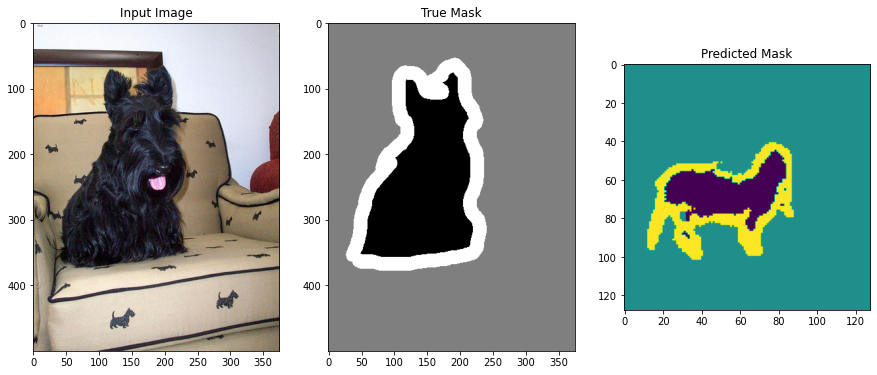

In [38]:
# display one sample prediction

i = 17

sample = load_image_and_mask(val_input_img_paths, val_target_img_paths, i)
prediction = prediction_to_img(val_preds[i])
sample += (prediction,)

display_sample(sample)

# It mismatches. Again.

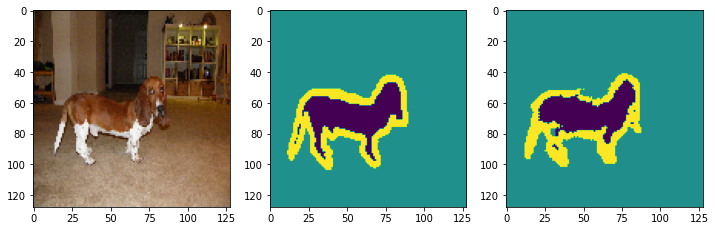

In [52]:
img_shape = (128, 128)
image_num_to_display = 17 # < batch_size
fig, axs = plt.subplots(1, 3, figsize=(12, 8))

for image, mask in val_gen:
  axs[0].imshow(image[image_num_to_display])
  axs[1].imshow([[mask[image_num_to_display][i][j][0] for j in range(img_shape[1])]
                 for i in range(img_shape[0])])
  axs[2].imshow(prediction_to_img(val_preds[image_num_to_display]))
  break

#### Task 4: Predict segmentation on your own pets



In [74]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/

tests = get_paths("pets_to_test_segmentation/", "jpg")

x = np.zeros((batch_size, *img_size, 3), dtype="float32")
for i in range(len(tests)):
    x_i = np.array(load_img(tests[i], target_size=img_size))
    x[i] = tf.cast(x_i, tf.float32) / 255.0

preds = model.predict(x)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks
1/1 [==============================] - 0s 102ms/step


In [75]:
def display_segmentation(image, prediction):
    plt.figure(figsize=(8, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.imshow(np.asarray(image))
    
    plt.subplot(1, 2, 2)
    plt.title('Predicted Mask')
    plt.imshow(np.asarray(prediction))

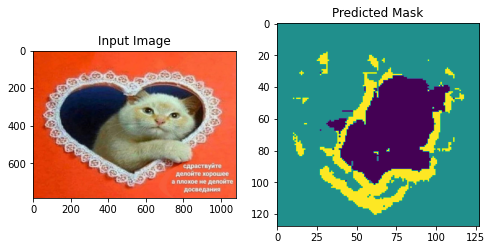

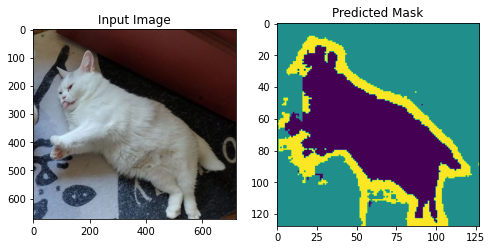

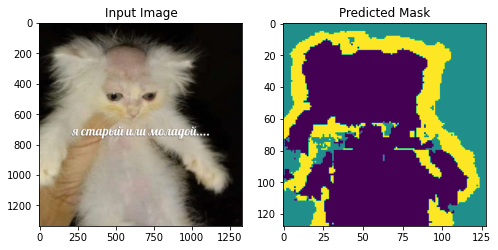

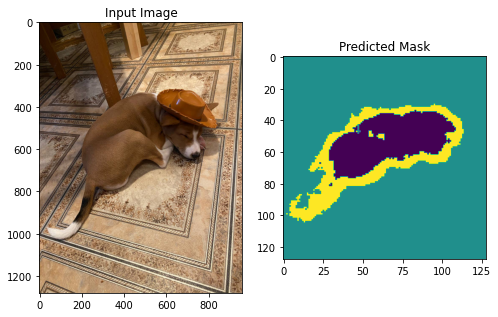

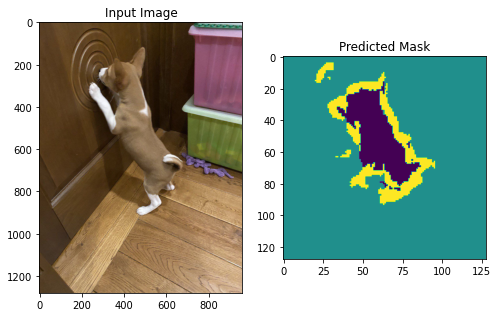

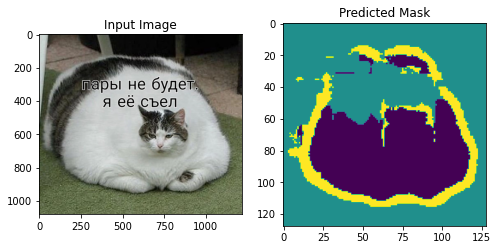

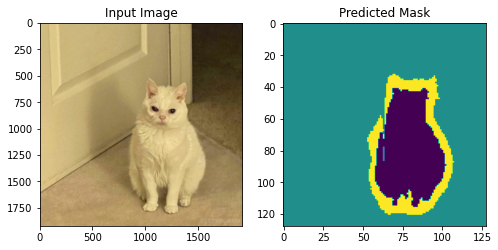

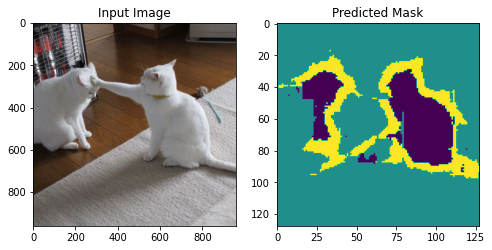

In [76]:
for i in range(len(tests)):
    image = load_img(tests[i])
    prediction = prediction_to_img(preds[i])
    display_segmentation(image, prediction)